1. Try optimal transport reprogramming data
2. Add similarity matrix
3. Use log only in loss function

#### Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

#### Test

In [3]:
from clonaltrans import main, config
device = torch.device("cuda:3")

config = config.Configuration()
config.learning_rate = 0.05
config.num_epochs = 2000
print (vars(config))

model = main.main(config, device)

{'gpu': 3, 'activation': 'gelu', 'seed': 42, 'alpha': 0.01, 'beta': 0.01, 'num_epochs': 2000, 'learning_rate': 0.05, 'paga_diagonal': True}
Topology graph loaded.
Input cell data (num_timepoints, num_clones, num_populations) loaded.
Background reference cells generated.
tensor(1873976.1250, device='cuda:3')


Delta 0.000, BaseK 0.000, Observation 0.000: 100%|██████████| 2000/2000 [1:27:28<00:00,  2.62s/it]


There are 2 observed timepoints except the inital time.


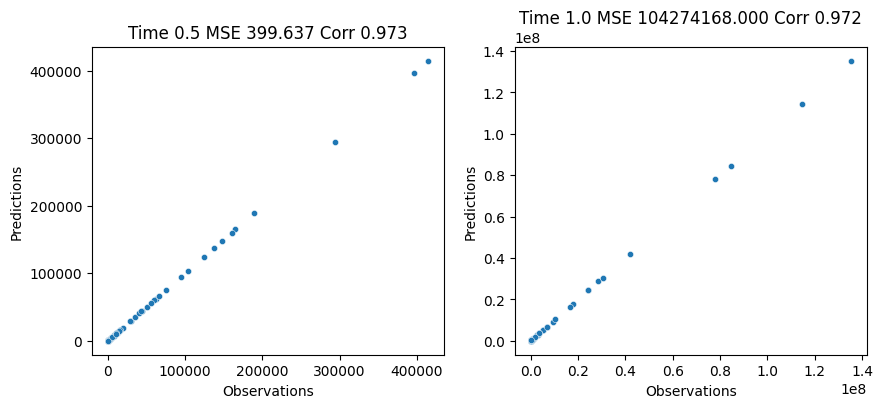

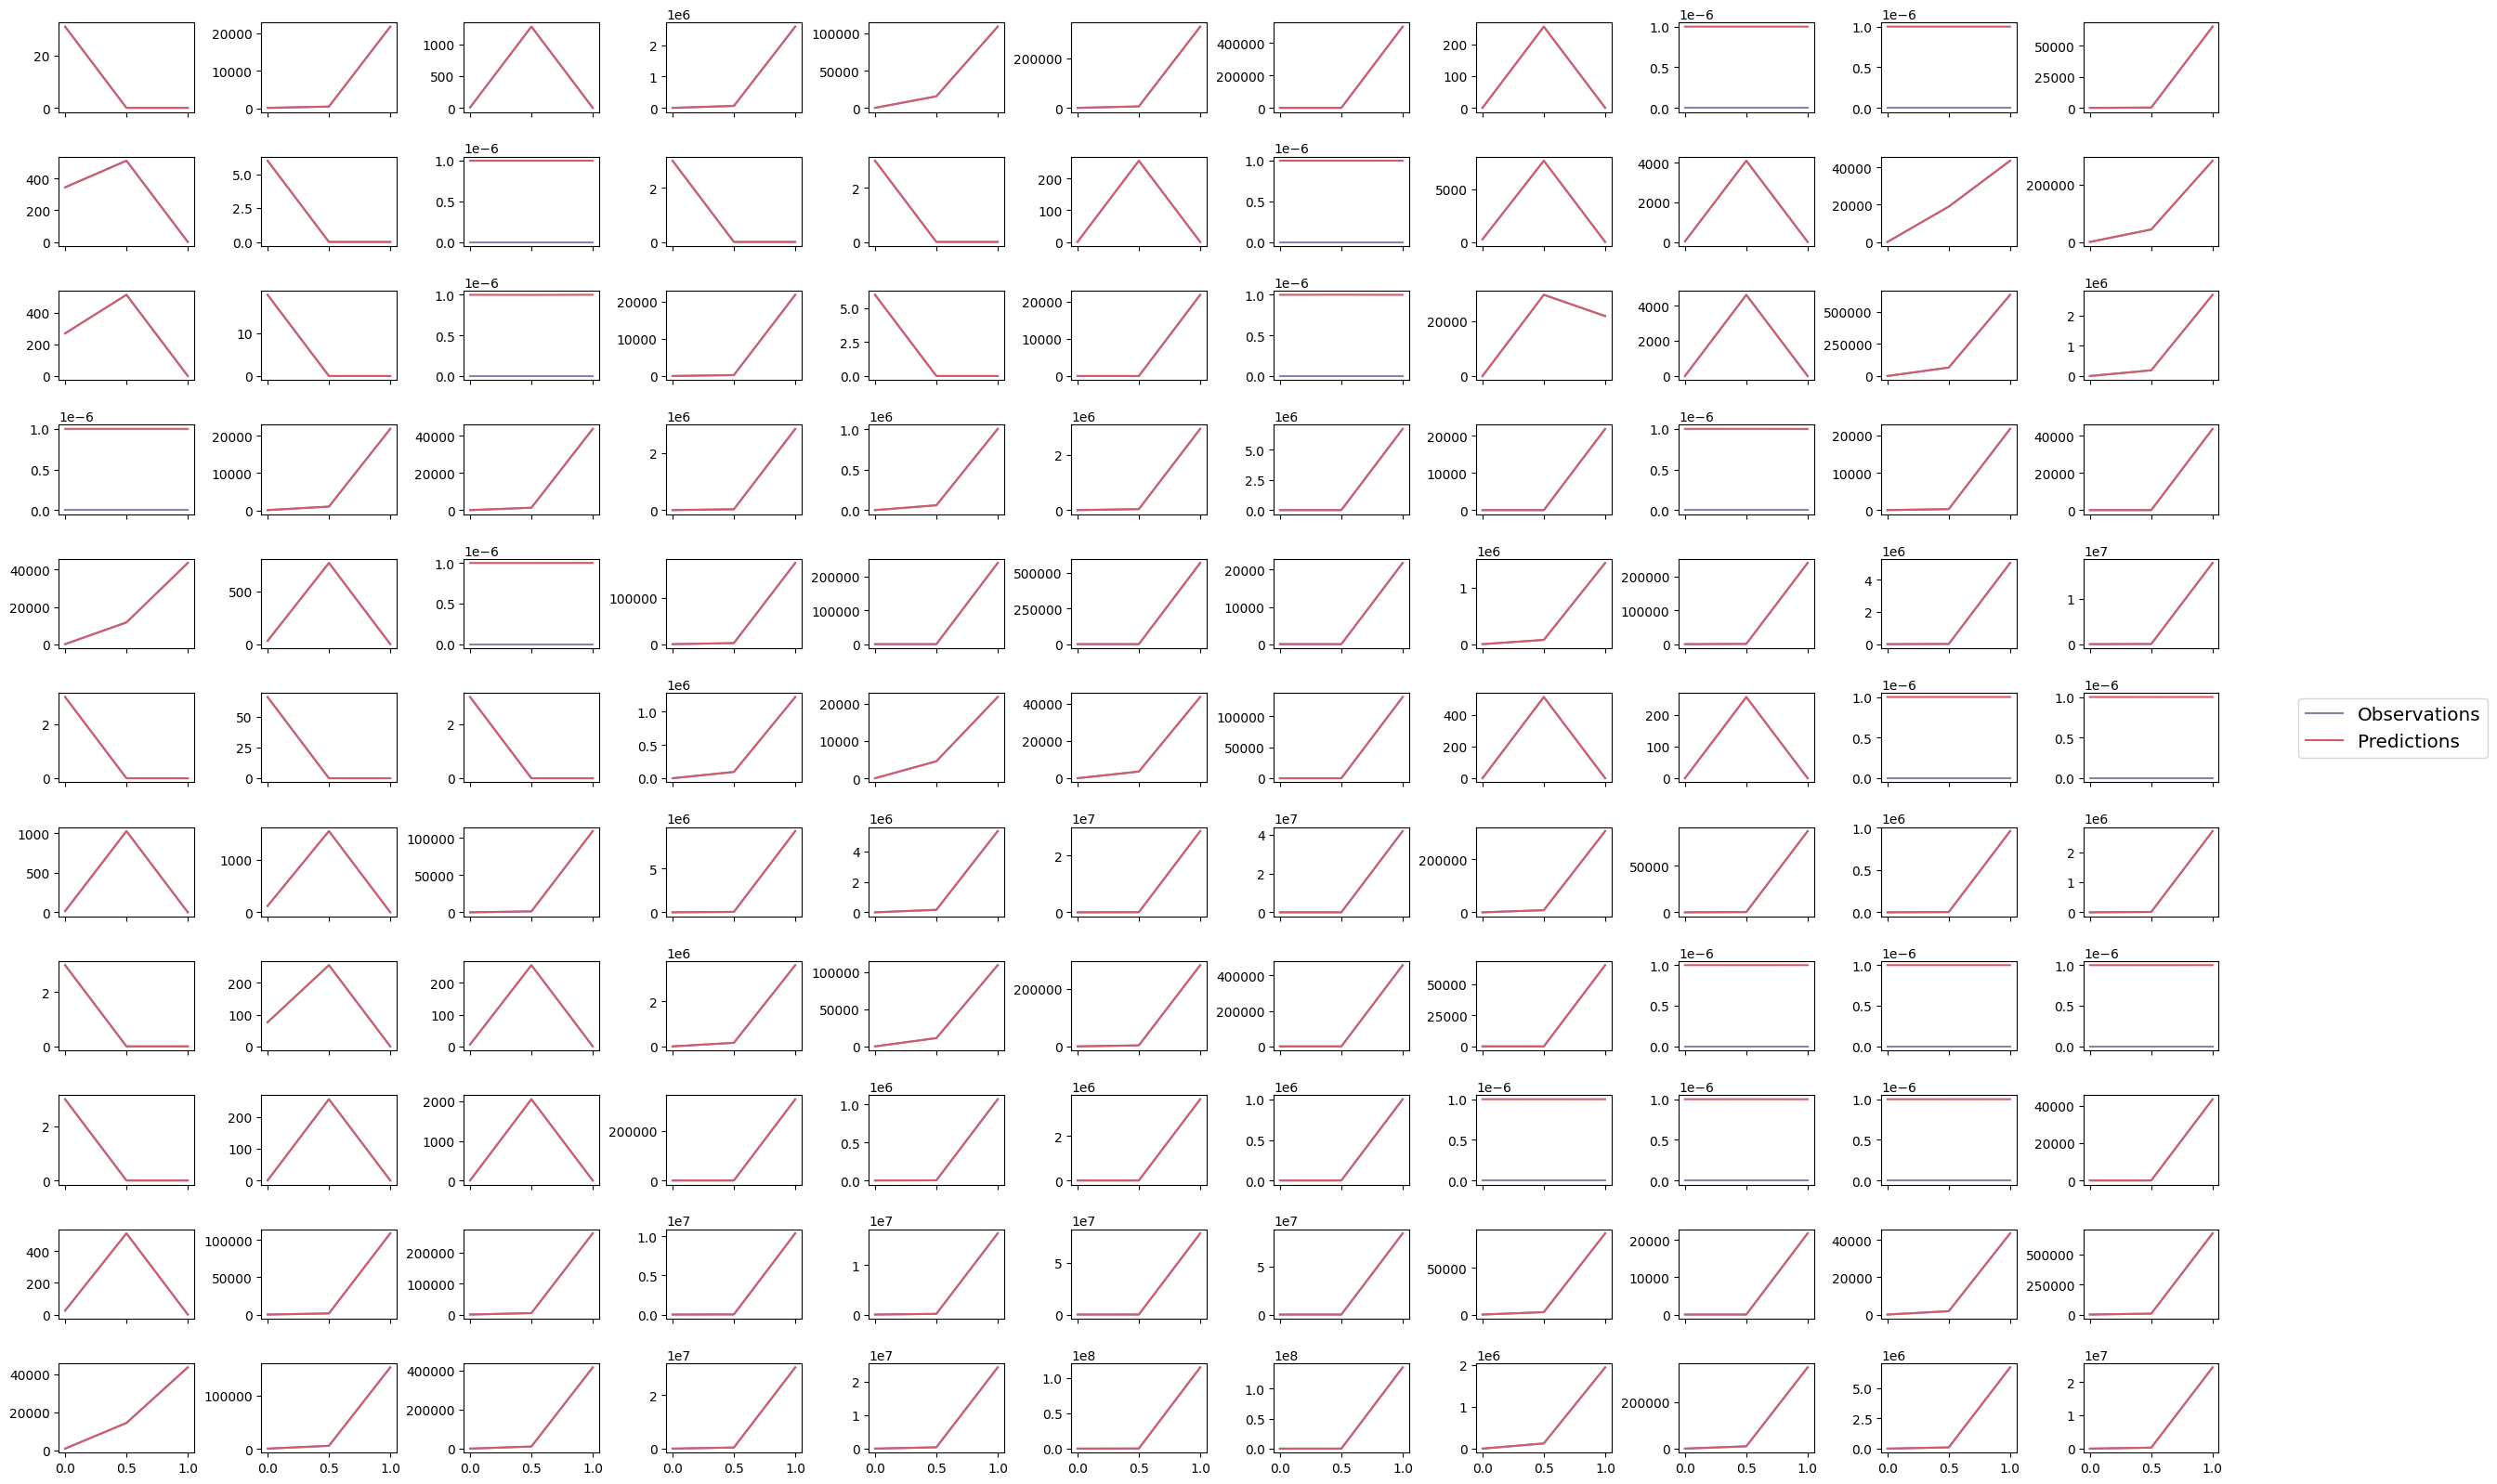

In [4]:
from clonaltrans import pl
t_observed = torch.tensor([3.0, 10.0, 17.0]).to(device)
t_observed = (t_observed - t_observed[0]) / (t_observed[-1] - t_observed[0])
pl.eval_predictions(model, t_observed)

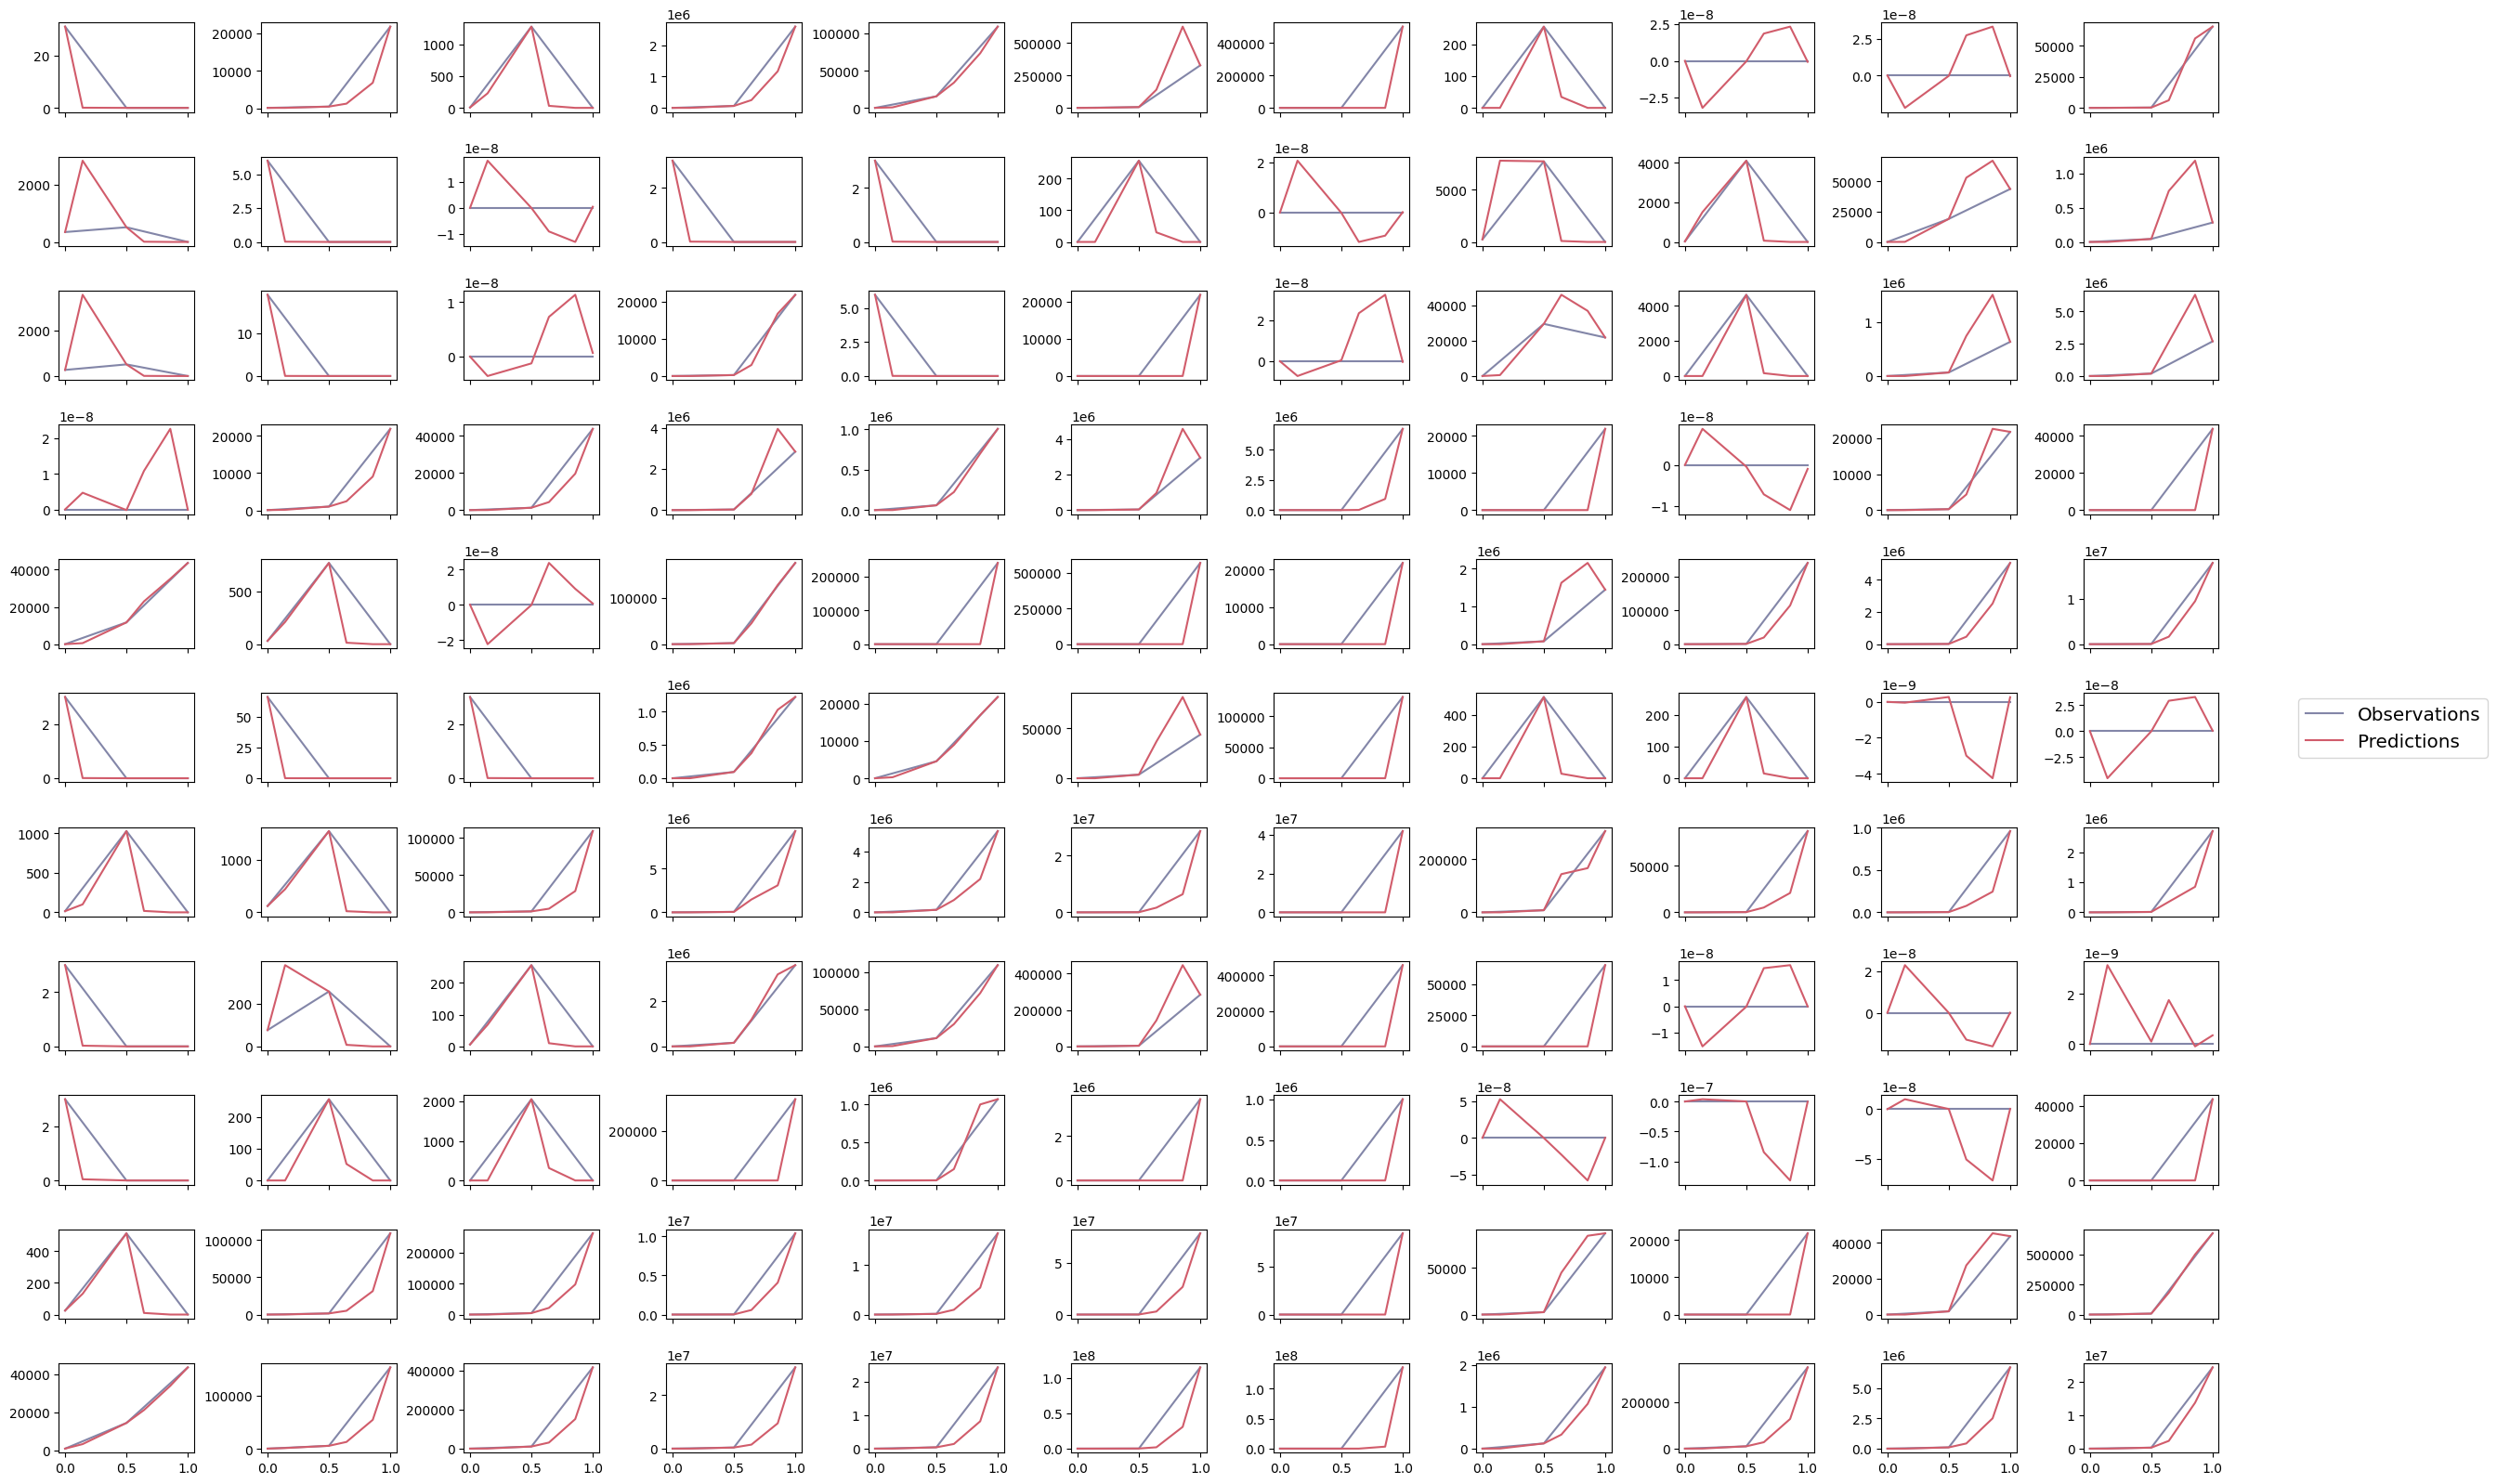

In [36]:
from clonaltrans import pl
t_observed = torch.tensor([3.0, 10.0, 17.0]).to(device)
t_observed = (t_observed - t_observed[0]) / (t_observed[-1] - t_observed[0])

t_pred = torch.tensor([3.0, 5.0, 10.0, 12.0, 15.0, 17.0]).to(device)
t_pred = (t_pred - t_pred[0]) / (t_pred[-1] - t_pred[0])
predictions = model.eval_model(t_pred)
pl.grid_visual_pred(model.N, predictions, t_observed, t_pred)

In [29]:
# Flatten the tensor and remove zeros
flat = tensor.flatten()
flat_nonzero = flat[flat != 0]

# Calculate maximum and minimum absolute values of non-zero elements
max_abs = np.amax(np.abs(flat_nonzero))
min_abs = np.amin(np.abs(flat_nonzero))

# Normalize non-zero elements to (-1, 1)
normalized = (flat_nonzero / max_abs) * 2 - 1

# Fill the original tensor with the normalized values
tensor_flat = np.zeros_like(flat)
tensor_flat[flat != 0] = normalized
normalized_tensor = tensor_flat.reshape((10, 11))


In [31]:
normalized_tensor

array([[ 0.        , -0.50251307,  0.        ,  0.        , -1.37034157,
         0.        ,  0.        ,  0.        , -1.22838041, -2.33894676,
         0.        ],
       [ 0.        ,  0.49343907,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        , -0.3343959 ,  0.        , -0.62245369,
        -0.4038839 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.11066281,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.48507951,  0.        ,  0.88812473,  0.33447236,  0.        ,
        -1.4214159 ],
       [ 0.        ,  0.        ,  0.74907532,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.35497714,  0.        , -1.2657728 ,  0.        , -1.40821184,
         0.        ,  0.        ,  0.        , -1.10658541,  0.        ,
        -1.135

In [24]:
K = model.matrix_K.detach().cpu().numpy()
for i in range(model.matrix_K.shape[0]):
    K[i] = (2 * (K[i] - K[i].min()) / (K[i].max() - K[i].min()) - 1) * (K[i] != 0)

In [8]:
torch.save(model, './model.pt')

In [1]:
import torch
model = torch.load('./examples/Gelu_Alpha0.01_Beta0.01_Epoch2000_LR0.05_Log/model.pt')

In [2]:
model.matrix_K[0]

tensor([[ 4.7698e-05,  8.0522e-06, -1.6868e-05, -2.1304e-05,  4.3549e-06,
         -2.6010e-05, -3.6299e-05, -3.5430e-05,  1.1404e-05, -3.7868e-06,
         -2.0744e-05],
        [ 1.7233e-05,  2.4214e-06, -2.8715e-05, -6.2380e-06,  2.0573e-06,
         -3.1106e-06,  5.5596e-05, -3.9093e-05, -5.2520e-06,  5.2736e-07,
          1.1623e-06],
        [ 3.6716e-05, -7.6811e-06,  4.0680e-06, -1.6233e-05,  2.7794e-05,
         -3.4600e-05, -4.3049e-05, -4.2036e-05,  5.5470e-06, -4.1472e-06,
         -2.6807e-05],
        [ 1.4342e-06, -1.1725e-05,  6.5126e-05, -1.2495e-05, -3.7001e-06,
         -1.0069e-05, -5.2549e-05,  5.6796e-05, -1.0561e-05, -1.7572e-06,
         -2.7838e-05],
        [ 5.4047e-05,  7.4506e-07, -3.4660e-05, -8.7395e-06,  9.6038e-06,
         -3.7551e-05,  3.4913e-05, -5.9783e-05, -1.9337e-05,  6.4857e-06,
         -5.6118e-05],
        [-9.4533e-05, -3.0708e-05,  4.0799e-05,  5.0731e-05, -5.8120e-05,
         -2.9564e-05,  2.5779e-05,  8.8811e-05, -1.5063e-05,  5.4426e-0